# Transfer Learning with TensorFlow
## Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.


In [ ]:
!nvidia-smi

Tue Oct 19 11:40:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get the data (10% of 10 food classes)

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")

zip_ref.extractall()

zip_ref.close()

--2021-10-19 11:40:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 172.217.219.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   131MB/s    in 1.2s    

2021-10-19 11:40:15 (131 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen

## Creating data loaders


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images: ")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

* TensorBoard callback
* ModelCheckpoint callback
* EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionize it)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard logfiles to {log_dir}")
  return tensorboard_callback

## Creating models using tensorflow hub

feature vector model from tensorflow hub : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  # Download the pretrained model and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, # Freeze the already learnt patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 
  # Create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Create ResNet model

In [ ]:
resnet_model = create_model(model_url=resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile the model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving Tensorboard logfiles to tensorflow_hub/resnet50V2/20211019-114031
Epoch 1/5
24/24 [==============================] - 60s 1s/step - loss: 1.8950 - accuracy: 0.3667 - val_loss: 1.1437 - val_accuracy: 0.6416
Epoch 2/5
24/24 [==============================] - 22s 958ms/step - loss: 0.8813 - accuracy: 0.7440 - val_loss: 0.8288 - val_accuracy: 0.7472
Epoch 3/5
24/24 [==============================] - 22s 941ms/step - loss: 0.5859 - accuracy: 0.8360 - val_loss: 0.7251 - val_accuracy: 0.7656
Epoch 4/5
24/24 [==============================] - 22s 940ms/step - loss: 0.4538 - accuracy: 0.8880 - val_loss: 0.6846 - val_accuracy: 0.7776
Epoch 5/5
24/24 [==============================] - 22s 936ms/step - loss: 0.3610 - accuracy: 0.9293 - val_loss: 0.6485 - val_accuracy: 0.7948


In [ ]:
# Create a function to plot the loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot Loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  plt.figure()

  # Plot Accuracy
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

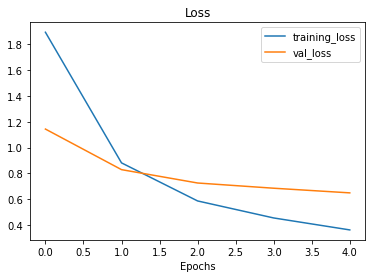

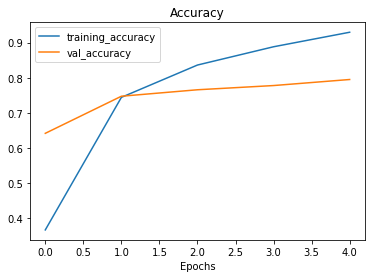

In [ ]:
plot_loss_curves(resnet_history)

## Create EfficientNetB0 model extractor

In [ ]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving Tensorboard logfiles to tensorflow_hub/efficientnetb0/20211019-115356
Epoch 1/5
24/24 [==============================] - 35s 1s/step - loss: 1.8513 - accuracy: 0.4573 - val_loss: 1.2849 - val_accuracy: 0.7472
Epoch 2/5
24/24 [==============================] - 19s 830ms/step - loss: 1.0432 - accuracy: 0.7800 - val_loss: 0.8507 - val_accuracy: 0.8272
Epoch 3/5
24/24 [==============================] - 19s 829ms/step - loss: 0.7394 - accuracy: 0.8320 - val_loss: 0.6839 - val_accuracy: 0.8488
Epoch 4/5
24/24 [==============================] - 19s 828ms/step - loss: 0.5968 - accuracy: 0.8627 - val_loss: 0.5996 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 19s 826ms/step - loss: 0.5032 - accuracy: 0.8880 - val_loss: 0.5479 - val_accuracy: 0.8620


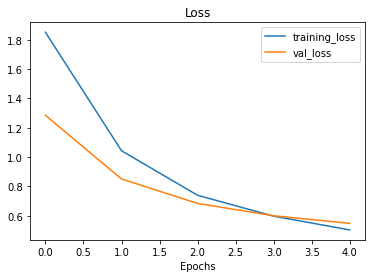

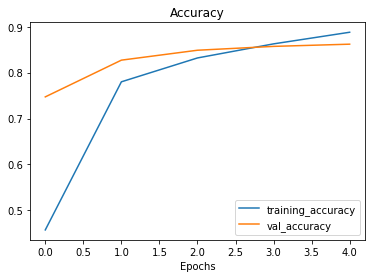

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning
* **`As is`** tranfer learning - using an existing model with no changes what so ever.

* **`Feature extraction`** transfer learning - use the prelearned patterns of an existing model and adjust the output layer for your own problem.

* **`Fine-tuning`** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).

# Comparing our model results using TensorBoard
🚨 When you upload things to tensorboard, your experiments are public

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2021-10-19 12:20:27.781951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 12:20:27.808632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 12:20:27.809362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

Tensorboard experiments are uploaded publicly here : https://tensorboard.dev/experiment/0EZj8YFmS1CvyHolZuY8QA/